# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy

# Data + EDA

### Synthetic Dataset

#### Data Generation

51.3 % positively labeled


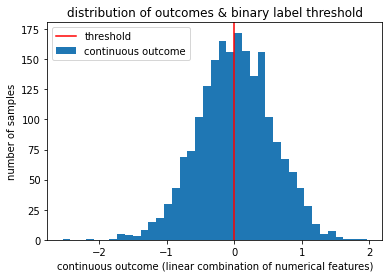

In [3]:
## create synthetic data as such:
# 3 numerical features (Gaussian), 1 categorical (sensitive attribute), 
# linear outcome model, s.t. outcome = Ind[effect_param*features > threshold]

# parameters
threshold = 0 # binary label threshold (outcome > threshold => label=1, else 0)
effect_param = [0.5, -0.2, 0.1] # causal effect parameter (to create outcomes)
n = 2000 # sample size
prop_noise = 0.01 # proportion of noisy binary labels (set to 0 for totally linear)

# categorical feature params
# required: len(cat_probabilities) = n_cat_features
n_cat_features = 2
cat_probabilities = [0.5, 0.5] 

# numerical feature params
num_feature_mean = [0, 0, 0]
num_feature_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# features
num_features = np.random.multivariate_normal(num_feature_mean, num_feature_cov, n)
cat_features = np.random.choice(np.arange(n_cat_features), n, cat_probabilities).reshape(n,1)

# outcomes
outcome_continuous = np.matmul(num_features,effect_param) # linear + no added noise
outcome_binary = np.where(outcome_continuous > threshold, 1, 0).reshape(n,1)

# binary label noise (flip prop_noise labels)
flip_idx = np.random.randint(0,n,int(n*prop_noise))
outcome_binary[flip_idx] = (outcome_binary[flip_idx]-1)*-1

# joint = [numerical features, categorical features, & binary outcome]
joint = np.hstack((num_features, cat_features, outcome_binary))

# print pct of positive labels (to check threshold)
print(round(np.mean(outcome_binary)*100,2), "% positively labeled")

# plot distribution of continuous outcomes & binary threshold 
plt.hist(np.matmul(num_features,effect_param),label='continuous outcome',bins='auto')
plt.axvline(threshold,color='red',label='threshold')
plt.xlabel("continuous outcome (linear combination of numerical features)")
plt.ylabel("number of samples")
plt.title("distribution of outcomes & binary label threshold")
plt.legend()
plt.show()

In [5]:
## add synthetic data to dataset list

# save to file
df_gaussian_synthetic = pd.DataFrame(pd.DataFrame(joint))
df_gaussian_synthetic.columns = ['num1','num2','num3','cat','outcome']
path_gaussian_synthetic = 'Datasets/gaussian_synthetic.csv'
df_gaussian_synthetic.to_csv(path_gaussian_synthetic)

# define Dataset object
cat = df_gaussian_synthetic.columns.values[-1]
num = df_gaussian_synthetic.columns.values[:-2]

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [11]:
df_synthetic = df_gaussian_synthetic

In [7]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [8]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [9]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [27]:
sens_attrs_syn = [df_synthetic['cat']]

### Data Preprocessing

In [14]:
# format data
X_syn = df_synthetic.iloc[:, :-1].values
y_syn = df_synthetic.iloc[:, -1].values

In [15]:
X_syn_true = X_syn
y_syn_true = y_syn

# Bias Injection

### Bias Injection

In [16]:
df_favored_syn = df_synthetic[df_synthetic['cat'] == 0]
df_unfavored_syn = df_synthetic[df_synthetic['cat'] == 1]

In [20]:
# unfavored group with negative label
df_unfavored_syn_negative = df_unfavored_syn[df_unfavored_syn['outcome'] == 0.0]


# unfavored group with positive label (preferred)
df_unfavored_syn_positive = df_unfavored_syn[df_unfavored_syn['outcome'] == 1.0]

# differences in label counts for unfavored group
print(df_unfavored_syn['outcome'].value_counts())

df_total_syn = pd.concat([df_favored_syn, df_unfavored_syn_negative])

1.0    521
0.0    497
Name: outcome, dtype: int64


### Under-Sampling Process

In [21]:
# under-sampling process
df_undersampled_syn = df_unfavored_syn_positive.sample(n=int(len(df_unfavored_syn_positive)*0.9), random_state=42)

# combine undersampled and original favored class to create dataset
df_concat_syn = pd.concat([df_total_syn,df_undersampled_syn])

# for fairness measures later
df_sens_syn = df_concat_syn['cat']

# format data
X_syn_bias = df_concat_syn.iloc[:, :-1].values
y_syn_bias = df_concat_syn.iloc[:, -1].values

X_syn_bias_true = X_syn_bias
y_syn_bias_true = y_syn_bias

print(X_syn_true.shape, X_syn_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())

(2000, 4) (1947, 4)


# Model

### Model Selection + Training (TODO: modularize)

In [22]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

# Synthetic Data
classifier_syn_true = classifier.fit(X_syn_true, y_syn_true)
y_syn_pred_truth = classifier_syn_true.predict(X_syn_true)

classifier_syn_bias = classifier.fit(X_syn_bias_true, y_syn_bias_true)
y_syn_pred_bias = classifier_syn_bias.predict(X_syn_bias_true)
y_syn_pred_bias_on_true = classifier_syn_bias.predict(X_syn_true)

### Model Performance (TODO: modularize)

In [28]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_syn_pred_truth, y_syn_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_syn_pred_bias, y_syn_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_syn_pred_bias_on_true, y_syn_true))

Synthetic Data

Accuracy of Ground Truth Model on Ground Truth Data:  0.9955
Accuracy of Biased Model on Biased Data:  0.9943502824858758
Accuracy of Biased Model on Ground Truth Data:  0.993


In [29]:
# Ground Truth Model on Ground Truth Data

fpr_true = MetricFrame(false_positive_rate, y_syn_true, y_syn_pred_truth, sensitive_features = sens_attrs_syn[0])
print("Overall Accuracy: ", fpr_true.overall)
print("Group Accuracy : ", fpr_true.by_group)

print("\n")
fnr_true = MetricFrame(false_negative_rate, y_syn_true, y_syn_pred_truth, sensitive_features = sens_attrs_syn[0])
print("Overall Selection Rate: ", fnr_true.overall)
print("Group Selection Rate : ", fnr_true.by_group)

Overall Accuracy:  0.003080082135523614
Group Accuracy :  cat
0.0    0.00628931
1.0             0
Name: false_positive_rate, dtype: object


Overall Selection Rate:  0.005847953216374269
Group Selection Rate :  cat
0.0    0.00792079
1.0    0.00383877
Name: false_negative_rate, dtype: object


# Fairness Intervention

In [35]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
np.random.seed(0)

#### Synthetic Data

In [30]:
constraint = EqualizedOdds()
mitigator_syn_true = ExponentiatedGradient(classifier_syn_true, constraint)
mitigator_syn_true.fit(X_syn_true, y_syn_true, sensitive_features = sens_attrs_syn[0])
y_syn_pred_mitigated_true = mitigator_syn_true.predict(X_syn_true)

In [31]:
constraint = EqualizedOdds()
mitigator_syn_bias = ExponentiatedGradient(classifier_syn_bias, constraint)
mitigator_syn_bias.fit(X_syn_bias_true, y_syn_bias_true, sensitive_features = df_sens_syn)
y_syn_pred_mitigated_bias = mitigator_syn_bias.predict(X_syn_bias_true)
y_syn_pred_mitigated_bias_on_true = mitigator_syn_bias.predict(X_syn_true)

# Evaluation

In [38]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [33]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_true, y_syn_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_bias_on_true, y_syn_true))

Synthetic Data

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9965
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.995


### Bias vs Accuracy vs Fairness Trade-Off

In [37]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(classifier, X_true, y_true, df_favored,
                           df_unfavored_positive, df_unfavored_negative,
                           sensitive_feature = "cat",
                           label = "outcome", cat_cols = [],
                           apply_fairness = False, verbose = False):
    
    bias_amts = list(range(0,30))
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
    dataset_size_bias = []

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

    for i in range(30):
        # under-sampling process
        if i != 0:
            df_undersampled = df_undersampled.sample(n=int(len(df_undersampled)*0.9), random_state=42)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored, df_unfavored_negative, df_undersampled])
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        X_bias_true = df_concat.iloc[:, :-1].values
        y_bias_true = df_concat.iloc[:, -1].values

        dataset_size_bias.append(X_bias_true.shape[0])
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        '''
        # fairness performance (TODO)
        eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
        eod_on_true.append(eod_true)

        eod_bias_on_true = equalized_odds_difference(y_true=y_true,\
        y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_biased.append(eod_bias_on_true)

        # table visualization 
        table_elem = [i*10, acc_bias, acc_bias_on_true]
        table.append(table_elem)
        '''
        
        if verbose:
            print("Finished Iteration: ", i)

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased,\
           accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [40]:
def accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()

In [41]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                        dataset_size_true, dataset_size_bias):
    plt.figure(figsize=(17,7))

    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend(loc = 3)

    plt.subplot(1,2,2)
    plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
    plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
    plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
    plt.ylabel("Dataset Size")
    plt.title("Amount of Minority Samples Removed vs Dataset Size")
    plt.legend()

    plt.show()

In [38]:
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

bias_amts, dataset_size_true, dataset_size_bias, \
accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(classifier, X_true=X_syn_true, y_true=y_syn_true, \
                       df_favored=df_favored_syn, df_unfavored_positive= df_unfavored_syn_positive,\
                       df_unfavored_negative= df_unfavored_syn_negative, sensitive_feature="cat",
                       cat_cols=[3], label = "outcome",
                       apply_fairness=True,verbose=True)

Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Iteration:  11
Finished Iteration:  12
Finished Iteration:  13
Finished Iteration:  14
Finished Iteration:  15
Finished Iteration:  16
Finished Iteration:  17
Finished Iteration:  18
Finished Iteration:  19
Finished Iteration:  20
Finished Iteration:  21
Finished Iteration:  22
Finished Iteration:  23
Finished Iteration:  24
Finished Iteration:  25
Finished Iteration:  26
Finished Iteration:  27
Finished Iteration:  28
Finished Iteration:  29


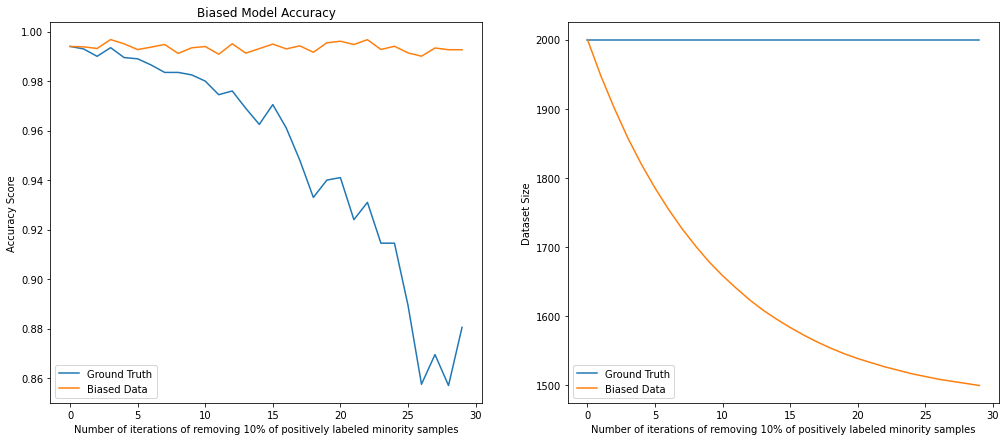

In [42]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

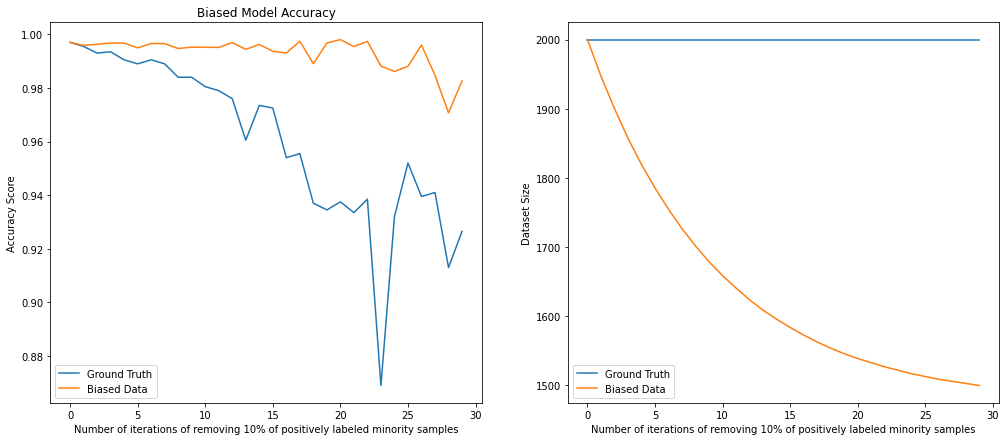

In [43]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

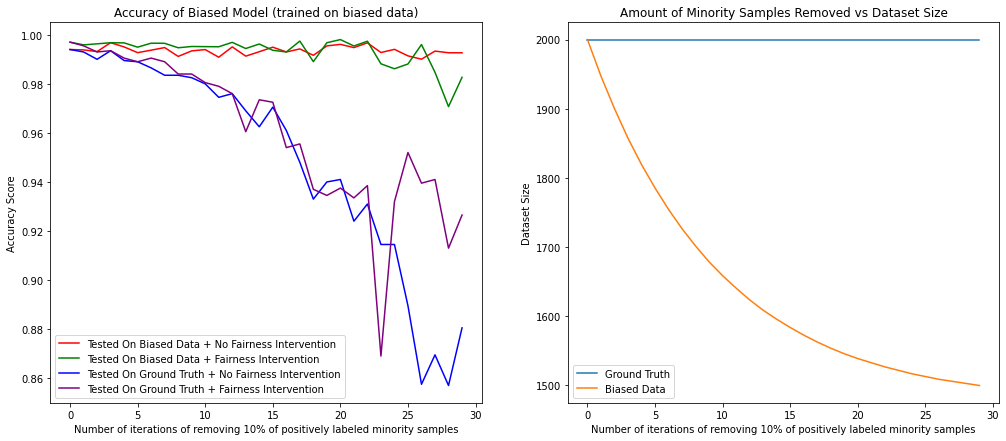

In [44]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                    dataset_size_true, dataset_size_bias)